### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import random

import glob
import os
import time
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

### Import data

In [2]:
DATA_DIR = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

data = []
for folder in glob.glob(DATA_DIR + '*'):
    if os.path.isdir(folder):
        folder_name = folder.split('/')[-1]
        for file in glob.glob(folder + '/*'):
            if 'mask' in file:
                image_file = file[:-9] + '.tif'
                ## Record presence of abnormality
                mask = np.max(cv2.imread(file))
                mask = 1 if mask else 0
                data.append([folder_name, image_file, file, mask])

df = pd.DataFrame(data, columns=['folder', 'image', 'mask', 'abnormality'])
df

,folder,image,mask,abnormality
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


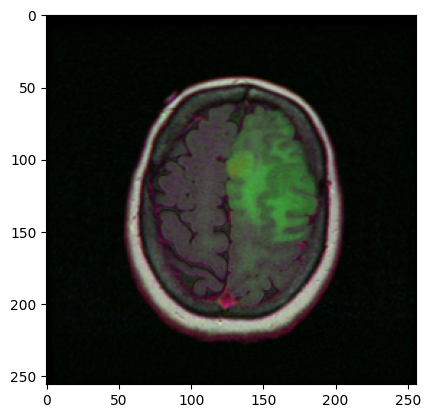

In [3]:
plt.imshow(cv2.imread(df.iloc[4]['image']))
plt.show()

1


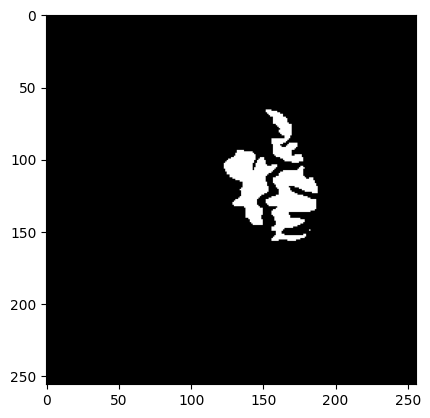

In [4]:
print(df.iloc[4]['abnormality'])
plt.imshow(cv2.imread(df.iloc[4]['mask']))
plt.show()

### Build dataset and model

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
transforms = A.Compose([
    A.Resize(width=256, height=256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(),
    ToTensorV2(),
])

In [7]:
class MRIDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx]['image'])
        mask = np.float32(cv2.imread(self.df.iloc[idx]['mask'], 0))

        transformed = self.transforms(image=image, mask=mask)

        return transformed['image'], transformed['mask']/255

In [8]:
train, val = train_test_split(df, stratify=df.abnormality, test_size=0.1)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

train, test = train_test_split(train, stratify=train.abnormality, test_size=0.15)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


train_dataset = MRIDataset(df=train, transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

val_dataset = MRIDataset(df=val, transforms=transforms)
val_loader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

test_dataset = MRIDataset(df=test, transforms=transforms)
test_loader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(DoubleConv, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)


class Down(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(Down, self).__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_chan, out_chan)
        )

    def forward(self, x):
        return self.model(x)


class Up(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(Up, self).__init__()
        self.convtrans = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = DoubleConv(in_chan, out_chan)

    def forward(self, x, x0):
        convtrans = self.convtrans(x)
        cat = torch.cat([x0, convtrans], dim=1)
        result = self.conv(cat)
        return result

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inconv = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
#         self.down4 = Down(512, 1024)
#         self.up4 = Up(1024, 512)
        self.up3 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up1 = Up(128, 64)
        self.outconv = nn.Conv2d(64, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = self.inconv(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
#         x4 = self.down4(x3)
#         x = self.up4(x4, x3)
        x = self.up3(x3, x2)
        x = self.up2(x, x1)
        x = self.up1(x, x0)
        x = self.outconv(x)
        x = self.sigmoid(x)
        return torch.squeeze(x)

In [11]:
unet = UNet().to(device)
result = unet(torch.randn(1,3,256,256).to(device))
print(result.shape)

torch.Size([256, 256])


### Loss function

In [12]:
def loss_func(predict, target):
    ## DICE loss
    smooth = 1
    intersection = smooth + 2*((target*predict).sum())
    union = target.sum() + predict.sum()
    diceloss = 1 - intersection/union
    # diceloss = - log(intersection/union)

    ## BCE loss
    bce = nn.BCELoss()
    bceloss = bce(predict, target)

    return bceloss + diceloss

### Train and validation loops

In [13]:
def train_epoch(model, loss_func, optimizer, loader):
    model.train()
    losses = []

    for data, targets in loader:
        data = data.to(device)
        predicts = model(data)
        targets = targets.to(device)
        
        loss = loss_func(predicts, targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(losses).mean()

def val_step(model, loss_func, loader):
    model.eval()
    losses = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            predicts = model(data)
            targets = targets.to(device)

            loss = loss_func(predicts, targets)
            losses.append(loss.item())

    return np.array(losses).mean()

### Train model

In [14]:
def train(model, loss_func, optimizer, train_loader, val_loader, num_epochs=30):
    train_history = []
    val_history = []

    for epoch in range(1,num_epochs+1):
        epoch_loss = train_epoch(model, loss_func, optimizer, train_loader)
        train_history.append(epoch_loss)

        val_loss = val_step(model, loss_func, val_loader)
        val_history.append(val_loss)

        # if epoch % 5 == 0:
        print(f'Epoch {epoch}:')
        print(f'Train loss = {epoch_loss}')
        print(f'Validation loss = {val_loss}\n')
    
    return train_history, val_history

In [15]:
%%time
unet = UNet().to(device)
num_epochs = 15
lr = 1e-3
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

train_history, val_history = train(unet, loss_func, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1:
Train loss = 1.1839551617359292
Validation loss = 1.0260918512940407

Epoch 2:
Train loss = 0.7762430883173285
Validation loss = 1.037894107401371

Epoch 3:
Train loss = 0.5515391752123833
Validation loss = 0.5198847418650985

Epoch 4:
Train loss = 0.48474134491949245
Validation loss = 0.5334401689469814

Epoch 5:
Train loss = 0.4197596958998976
Validation loss = 0.5578998941928148

Epoch 6:
Train loss = 0.4131039083003998
Validation loss = 0.4049000283703208

Epoch 7:
Train loss = 0.3791635953660669
Validation loss = 0.45869559701532125

Epoch 8:
Train loss = 0.3679916310156214
Validation loss = 0.4258923204615712

Epoch 9:
Train loss = 0.36811445068953363
Validation loss = 0.478151454590261

Epoch 10:
Train loss = 0.3545661882079881
Validation loss = 0.3220017314888537

Epoch 11:
Train loss = 0.3467128221587888
Validation loss = 0.3339378144592047

Epoch 12:
Train loss = 0.34421670475396615
Validation loss = 0.3266446441411972

Epoch 13:
Train loss = 0.32543580156975777
Vali

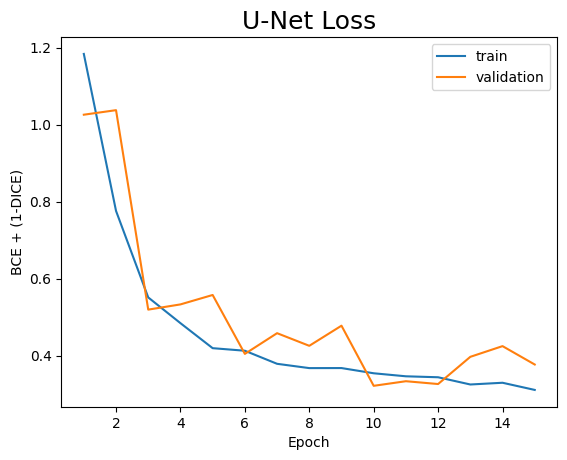

In [19]:
plt.plot(range(1,num_epochs+1), train_history, label='train')
plt.plot(range(1,num_epochs+1), val_history, label='validation')

plt.title('U-Net Loss', fontsize=18)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('BCE + (1-DICE)')
plt.show()

In [20]:
test_loss = val_step(unet, loss_func, test_loader)
print(test_loss)

0.3226776399782726


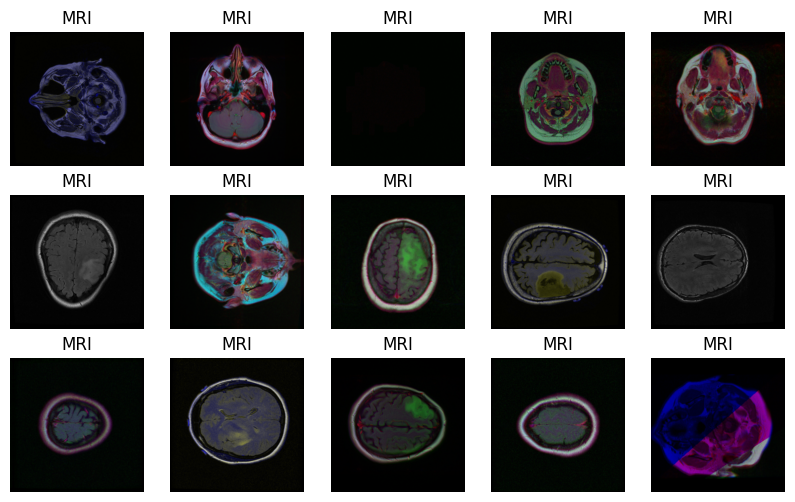

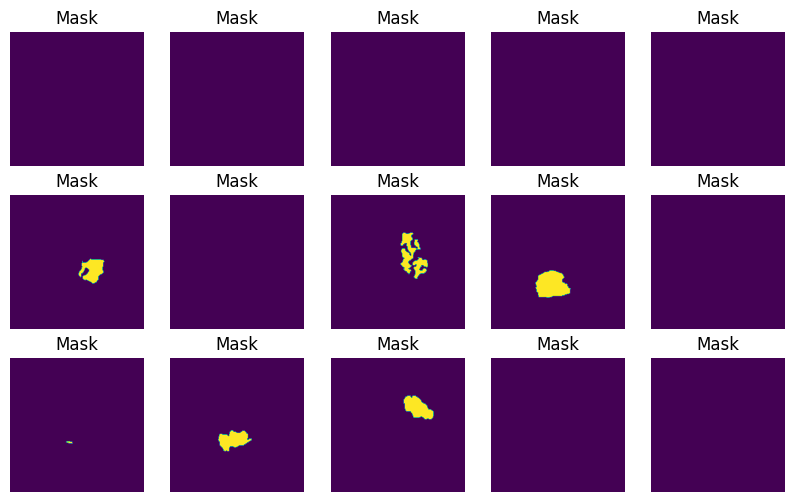

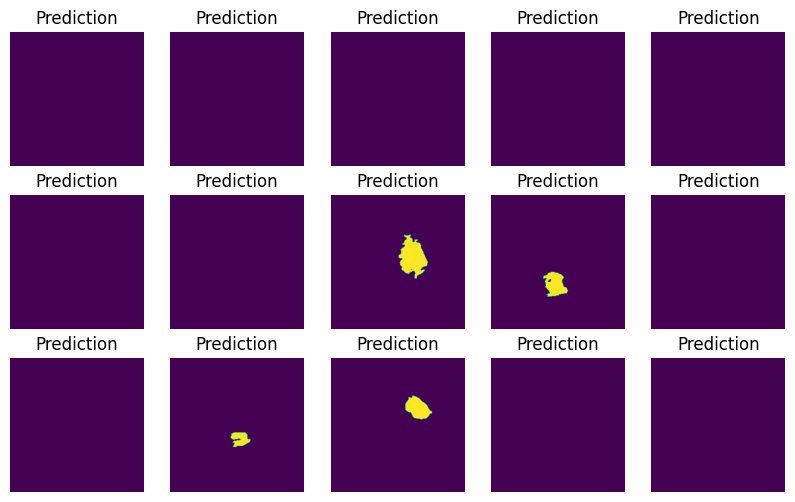

In [21]:
def test_results(inputs, nrows=3, ncols=5, unnorm=True, title='MRI'):
    plt.figure(figsize=(10,6))
    
    if len(inputs) > nrows*ncols:
        inputs = inputs[:nrows*ncols]
        
    for jj in range(len(inputs)):
        if unnorm:
            image = inputs[jj].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            image = (image*std+mean).astype(np.float32)
        else:
            image = inputs[jj]
            
        plt.subplot(nrows, ncols, jj+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)
        
    return plt.show()

images, masks = next(iter(test_loader))

unet.eval()
with torch.no_grad():
    predicts = unet(images.to(device))

predicts = predicts.detach().cpu().numpy()

threshold = 0.3
predicts_b = np.copy(predicts)
predicts_b[np.nonzero(predicts<threshold)] = 0
predicts_b[np.nonzero(predicts>=threshold)] = 1

test_results(images)
test_results(masks, unnorm=False, title='Mask')
test_results(predicts_b, unnorm=False, title='Prediction')

In [ ]:
test_samples = test[test['abnormality'] == 1].sample(5).values[0]
image = cv2.imread(test_samples[1])
mask = cv2.imread(test_samples[2])

predict = torch.tensor(image.astype(float32)/255)
predict = unet()